In [5]:
# Imports

## General
import os 
import sys
sys.path.append(".")
from RNN_helpers import *
import pprint as pp

## Numerical
import numpy as np
import pandas as pd
import scipy.stats as sps
from scipy.stats import linregress, wilcoxon

## Plotting
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sb

## Data
import pandas as pd
import pyabf
import xarray as xr

# Plotting defaults

In [2]:
# Plotting defaults and functions

%config InlineBackend.figure_format = 'retina'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.labelsize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['axes.formatter.limits'] = [-2, 3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', family='Arial')
plt.rcParams['figure.dpi'] = 150

#Setting Colors
R_COLOR = "#808080"
R_NO_STDP_COLOR = "#B3B3B3"
NNR_COLOR = '#FF767C'
NNR_NO_STDP_COLOR = "#FFBFC1"

PRE_STDP_COLOR = ".6"
STDP_COLOR = "#6214FF"
STDP_SHUFFLE_COLOR = "#BA98FF"
STDP_MEAN_COLOR = "#98DDFF"
STDP_CONTROL_COLOR = "#BA98FF"

NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NNR_COLOR, R_COLOR], N=1000)


In [3]:
%load_ext autoreload 
%autoreload 2

# Behavioral performance

### Rat

In [4]:
RAT_DIR = os.path.join(".", "data", "rat") 
RAT_BEHAVIOR_FILE = os.path.join(RAT_DIR, "rat_behavioral_data.csv")

In [5]:
rat_behavior_df = pd.read_csv(RAT_BEHAVIOR_FILE)

print(f"N_rat = {len(rat_behavior_df)}")

N_rat = 15


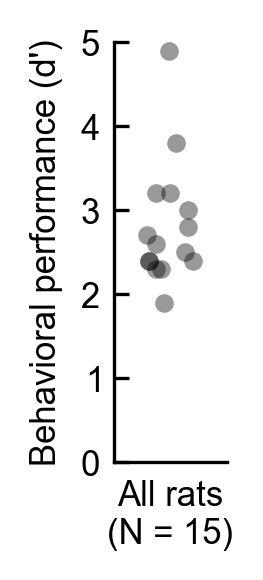

In [19]:
NAME = "rat_behavior"

fig, ax = plt.subplots(figsize=(.75, 2), gridspec_kw={'left':.4, 'bottom':.18})
plot_violin_scatter(ax, 0, rat_behavior_df["D_prime"], summary_size=30, size=20, summary=False)
ax.set_xlim(-.5, .5)
ax.set_ylim(0, 5)
ax.set_xticks([])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_ylabel("Behavioral performance (d')", size="small")
ax.set_xlabel("All rats\n(N = 15)")

fig.tight_layout()
fig.savefig(os.path.join(RAT_DIR, NAME + ".pdf"))
fig.savefig(os.path.join(RAT_DIR, NAME + "_300.png"), dpi=300)

In [23]:
data = rat_behavior_df["D_prime"]
mean = np.mean(data)
sem = np.std(data) / len(data)

print(f"d' = {mean:.2f} +/- {sem:.2f}")

test = wilcoxon(data)
print(test)


d' = 2.83 +/- 0.05
WilcoxonResult(statistic=0.0, pvalue=6.103515625e-05)


### Mouse 

In [9]:
MOUSE_DIR = os.path.join(".", "data", "mouse") 
MOUSE_BEHAVIOR_FILE = os.path.join(MOUSE_DIR, "mouse_behavioral_data.csv")
mouse_behavior_df = pd.read_csv(MOUSE_BEHAVIOR_FILE)
print(f"N_mouse = {len(mouse_behavior_df)}")

N_mouse = 7


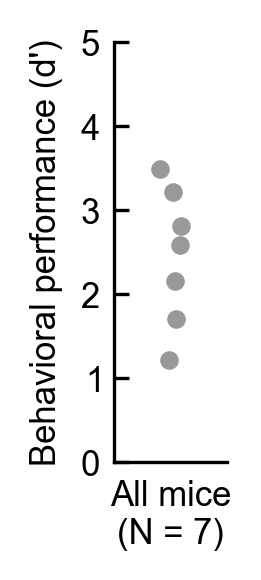

In [14]:
NAME = "mouse_behavior"

fig, ax = plt.subplots(figsize=(.75, 2), gridspec_kw={'left':.4, 'bottom':.18})
plot_violin_scatter(ax, 0, mouse_behavior_df["D_prime"], summary_size=30, size=20, summary=False)
ax.set_xlim(-.5, .5)
ax.set_ylim(1, 5)
ax.set_xticks([])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.set_ylabel("Behavioral performance (d')", size="small")
ax.set_xlabel("All mice\n(N = 7)")

plt.tight_layout()
fig.savefig(os.path.join(MOUSE_DIR, NAME + ".pdf"))
fig.savefig(os.path.join(MOUSE_DIR, NAME + "_300.png"), dpi=300)

In [22]:
data = mouse_behavior_df["D_prime"]
mean = np.mean(data)
sem = np.std(data) / len(data)

print(f"d' = {mean:.2f} +/- {sem:.2f}")

test = wilcoxon(data)
print(test)


d' = 2.45 +/- 0.11
WilcoxonResult(statistic=0.0, pvalue=0.015625)


# Modulation distributions 

## Rat

In [8]:
RAT_DIR = os.path.join(".", "data", "rat")
RAT_STATISTICS_FILE = os.path.join(RAT_DIR, "rat_neuron_statistics.csv")

### PSTHs

In [18]:
rat_statistics_df = pd.read_csv(RAT_STATISTICS_FILE, index_col=0)
VARS = ["region", "animal", "neuron", "R_st", "R_ch", "R", "frac_3"]
idx = (rat_statistics_df["region"] == 'AC') # & (rat_statistics_df["frac_3"] >= .8)
rat_statistics_df_2 = rat_statistics_df.loc[idx, VARS]
rat_statistics_df_2 = rat_statistics_df_2.sort_values("R_st", ascending=False)

sorted_df = rat_statistics_df_2.set_index(["animal", "neuron"])


In [11]:
def roll_up_spikes(r0):
    spikes = []
    trials = []
    n_trials = r0.shape[0]
    for t, current_spikes in enumerate(r0):
        trials.extend(len(current_spikes)*[t])
        spikes.extend(current_spikes)
    return(np.array(spikes)*1000, np.array(trials),  n_trials)

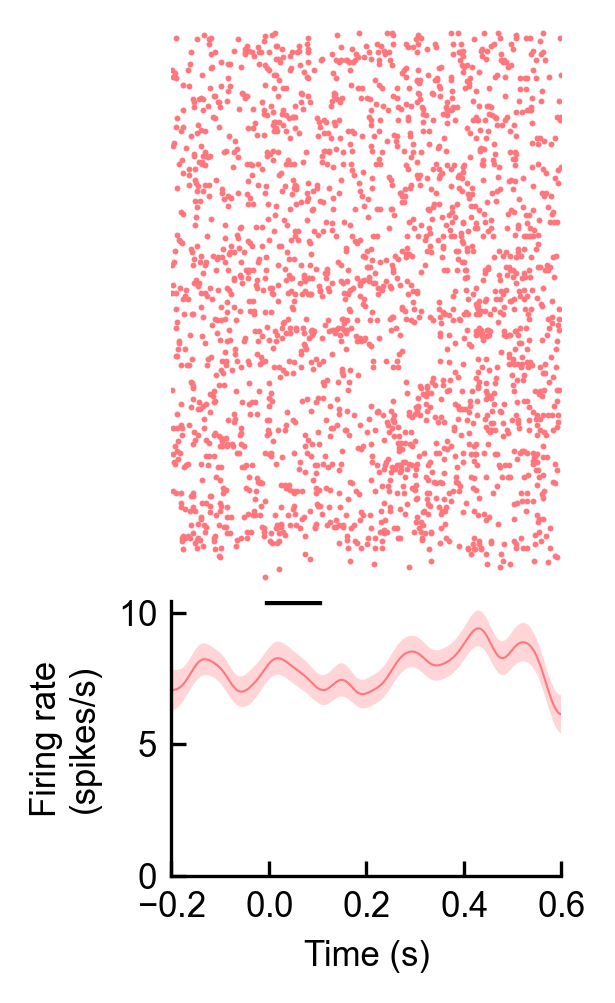

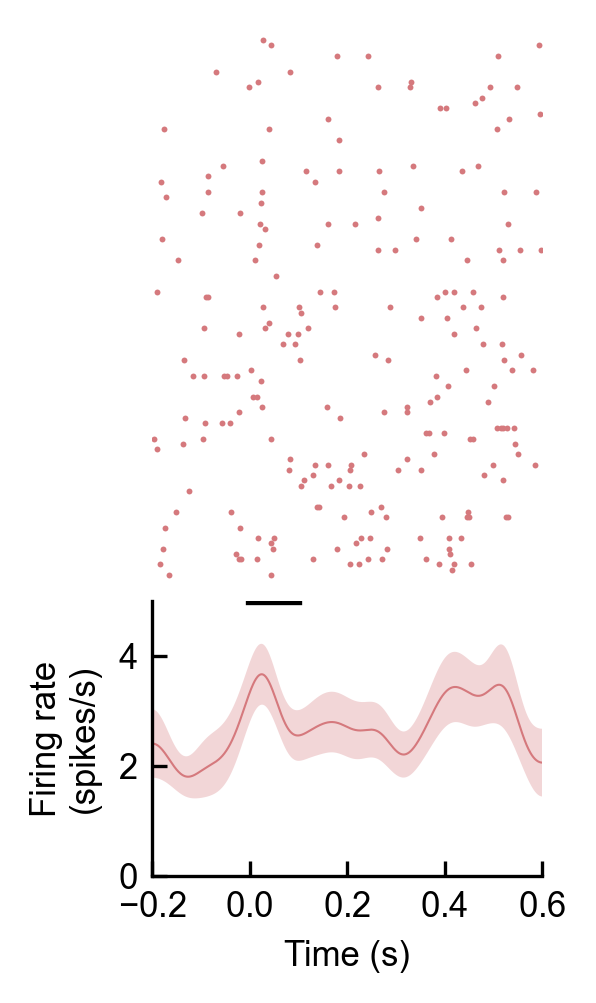

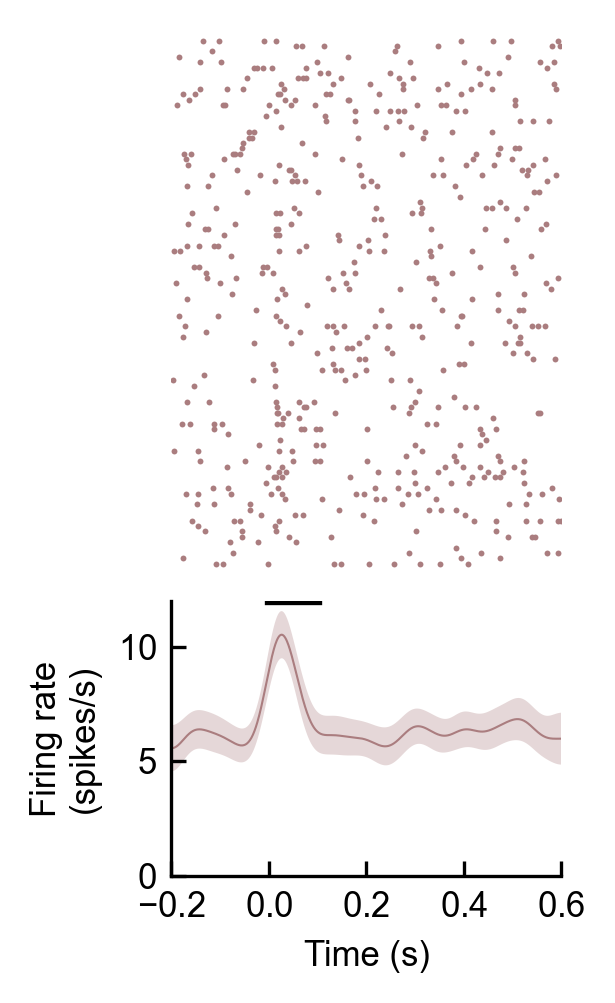

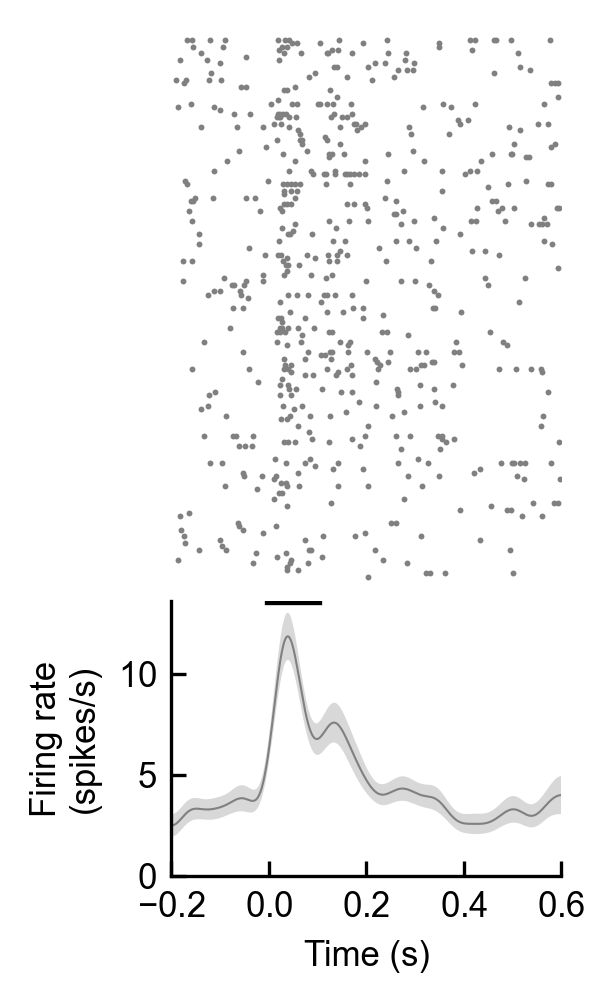

In [12]:
# Selected neurons 

UNITS = [ ("AC_12132016", 0), ("AC_09192013_RS", 7), ("AC_04212014", 0), ("AC_02272014", 1)]
COLORS = [NCR_CR_cmap(i) for i in np.linspace(0, 1, len(UNITS))]

for i, (unit, color) in enumerate(zip(UNITS, COLORS)):
    animal, neuron = unit
    R_st, R_ch, R = sorted_df.loc[unit][["R_st", "R_ch", "R"]]
    event_set, spike_set = mb.load_events_spikes_script(neuron_num=[neuron], base_dir=RAT_CODE_DIR, **ANIMALS[animal])
    try:
        st0, s0, a0, np0, r0 = mb.create_complete_table(event_set, spike_set, ANIMALS[animal]['variables'], trial_duration = 2, pre_trial_duration = 2)
        spikes, trials, n_trials = roll_up_spikes(r0[0])
        fig, ax_PSTH, ax_raster = plot_raster_PSTH(spikes, trials, n_trials, show_avg_FR=False, scotts_factor=.4, figsize=(2,4), raster_size=2, raster_color=color, avg_FR_color=color, var_FR_color=color, var_FR_alpha=.3, gridspec_kw={'bottom': .175, 'left': .25, 'hspace': .05, 'height_ratios':[2,1]})
    except:
        raise

    fig.savefig(os.path.join(RAT_DIR, "PSTHs_final", f"{i} {R:.02} {R_st:.02} {R_ch:.02} - {animal} {neuron}.pdf"))

### Summary

In [13]:
EXP_NAME = "gross_STDP"
DIR = "../results_experiments/results_experiment_LIFv2_gross_stdp_halftauIE_x16/"
REMOVE_INACTIVE = True
INACTIVE_THRESH = 3.3

df1 = pd.read_csv(DIR + "calculate_responsiveness.csv", index_col=0)

s = {}
c = {}
r = {}
d = {}
labels = []
for EE_stdp, IE_stdp in [(True, True)]:
    if (IE_stdp, EE_stdp) == (False, False):
        label = "Pre-STDP"
    elif (IE_stdp, EE_stdp) == (True, False):
        label = "IE only"
    elif (IE_stdp, EE_stdp) == (False, True):
        label = "EE only"
    elif (IE_stdp, EE_stdp) == (True, True):
        label = "Spiking RNN"
    s[label] = []
    c[label] = []
    r[label] = []
    d[label] = 0
    c_df = df1[(df1["IE_stdp"] == IE_stdp) & (df1["EE_stdp"] == EE_stdp)]
    for row in c_df.iterrows():
        for j in range(1, 1001):
            try:
                resp = eval(row[1][str(j)])
                # if resp["responsiveness"] < 8: continue
                if REMOVE_INACTIVE & (resp['fr_mean'] < 6.6):
                    d[label] += 1
                else:
                    s[label].append(resp["s_mean"])
                    c[label].append(resp["c_mean"])
                    r[label].append(resp["responsiveness"])
            except:
                raise

df2 = pd.read_csv(RAT_STATISTICS_FILE, index_col=0)

label = "In vivo (rat)"
c_df = df2[df2["region"] == "AC"]
s[label] = []
c[label] = []
r[label] = []
d[label] = 0
for i, row in c_df.iterrows():
    try:
        if REMOVE_INACTIVE and (row["frac_3"] < .80 ):
             d[label] += 1
        else:
            s[label].append(row["R_st"])
            c[label].append(row["R_ch"])
            r[label].append(row["R"])
    except:
        raise



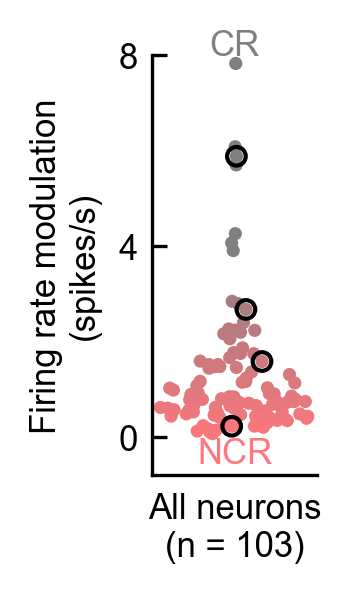

In [20]:
NAME = "rat_modulation"
highlights = np.array([i in UNITS for i in sorted_df.index])

fig, ax = plt.subplots(figsize=(1.1, 2), gridspec_kw={'left':.4, 'bottom':.18})

plot_violin_scatter(ax, 0, sorted_df["R"], highlights=highlights, summary_size=30, size=10, width=2, summary=False, color=NCR_CR_cmap(sorted_df["R"]/4), alpha=1)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.8, 8)
ax.set_xticks([])
ax.set_yticks(range(0, 9, 4))

ax.text(0, 0, "NCR", color=NNR_COLOR, ha="center", size='small', va="top")
ax.text(0, 8, "CR", color=R_COLOR, ha="center", size='small')

ax.set_ylabel("Firing rate modulation\n(spikes/s)")
ax.set_xlabel(f'All neurons\n(n = {len(sorted_df["R"])})')


fig.savefig(os.path.join(RAT_DIR, NAME + ".pdf"))
fig.savefig(os.path.join(RAT_DIR, NAME + "_300.png"), dpi=300)

In [21]:
print(np.median(sorted_df["R"]), np.percentile(sorted_df["R"], 75), np.percentile(sorted_df["R"], 25))

0.7872808272798909 1.495106445368372 0.46876004887774136


### Comparison to RNN 

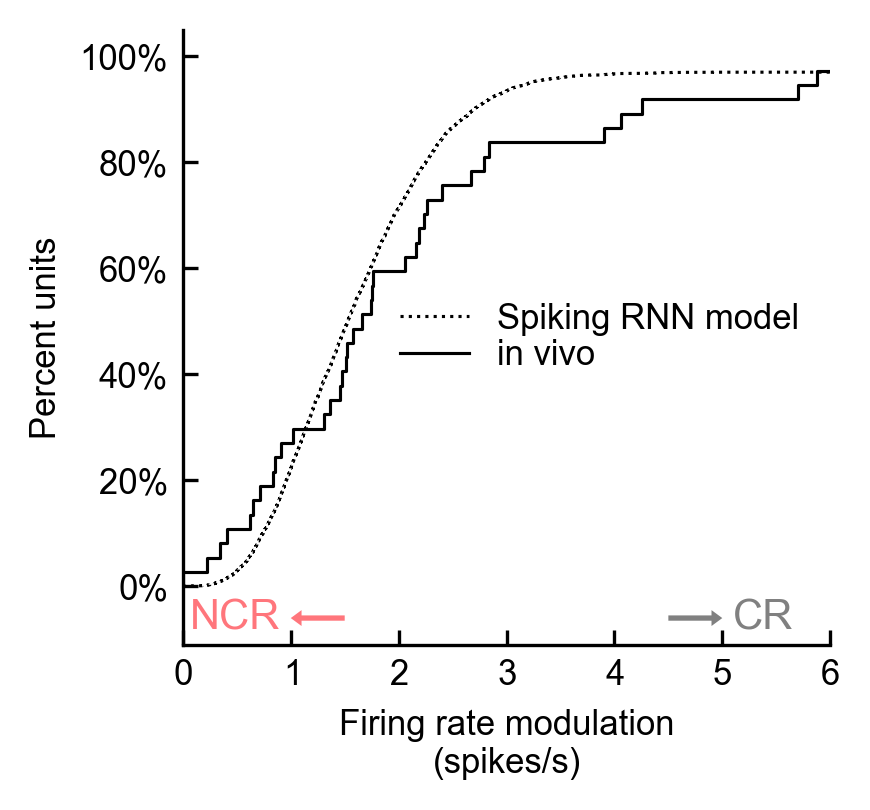

In [ ]:
NAME = "RNN_vs_in_vivo_comparison"

fig, ax = plt.subplots(figsize=(3, 2.8))
_ = makeCDF(ax, r["Spiking RNN"], xmax=14, label="Spiking RNN model", lw=.75, color='k', linestyle=":")
# _ = makeCDF(ax, r_3["Pre-STDP"], xmax=14, label="Pre-STDP", lw=.75, color='k', linestyle="--")
_ = makeCDF(ax, r["In vivo (rat)"], xmax=14, label="in vivo", lw=.75, color='k')
ax.set_xlim([0,6])
ax.set_yticks(np.arange(0, 1.2, .2))
ax.set_yticklabels([f"{int(i*100)}%" for i in ax.get_yticks()])
ax.set_xlabel("Firing rate modulation\n(spikes/s)")
ax.set_ylabel("Percent units")
ax.legend(labelspacing=.1, loc='right')
add_NCR_CR_scale(ax, hoffset=0.9, voffset=.05, height=0.06)

# fig.savefig(os.path.join(MOUSE_DIR, NAME + ".pdf"))
fig.savefig(os.path.join(RAT_DIR, NAME + ".pdf"))

In [ ]:
print(sps.stats.kstest(r["Spiking RNN"], r["In vivo (rat)"]))
print(sps.stats.mannwhitneyu(r["Spiking RNN"], r["In vivo (rat)"]))

KstestResult(statistic=0.1618872393520281, pvalue=0.2737469619682241)
MannwhitneyuResult(statistic=127300.0, pvalue=0.14367202324511164)


## Mouse

In [106]:
MOUSE_STATISTICS_FILE = os.path.join(".", "data", "mouse", "mouse_neuron_statistics.csv")

mouse_resp_df = pd.read_csv(MOUSE_STATISTICS_FILE, index_col=0)
mouse_resp_df_2 = mouse_resp_df[mouse_resp_df["n_spikes_avg"] > 1]
mouse_resp_df_2 = mouse_resp_df_2.sort_values("R")
mouse_resp_df_2 = mouse_resp_df_2.sort_values("R_st", ascending=False)
mouse_resp_df_2

,date,animal,cell_num,stim_time,R_st,R_ch,R,frac_1,frac_3,n_spikes_avg
23,2020-01-24,mni13,2,200.0,41.264368,1.206897,41.282014,0.965517,0.965517,83.103448
27,2020-01-25,mni13,3,200.0,26.733333,5.900000,27.376653,0.980000,0.980000,24.920000
20,2019-12-17,mni11,4,200.0,8.333333,3.000000,8.856887,0.900000,0.866667,14.100000
8,2019-10-03,mni07,1,100.0,5.466667,-1.100000,5.576239,0.980000,0.980000,37.460000
24,2020-01-24,mni13,3,200.0,4.533333,-0.100000,4.534436,0.860000,0.700000,7.360000
19,2019-12-17,mni11,3,200.0,3.564103,0.923077,3.681698,0.853846,0.638462,6.446154
3,2019-08-26,mni05,2,100.0,3.484848,8.409091,9.102581,0.727273,0.500000,9.863636
29,2020-02-12,mni14,4,200.0,2.333333,0.700000,2.436072,0.980000,0.780000,5.260000
4,2019-08-27,mni05,1,100.0,2.266667,0.800000,2.403701,0.800000,0.560000,4.560000
14,2019-12-11,mni10,1,200.0,2.233333,-0.450000,2.278218,0.985000,0.950000,23.175000


### PSTHs

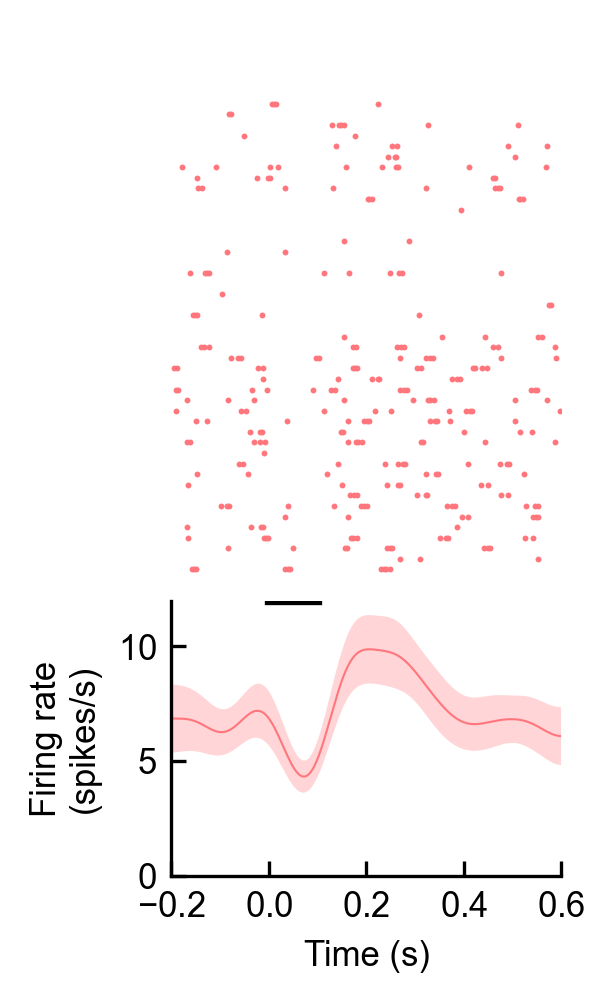

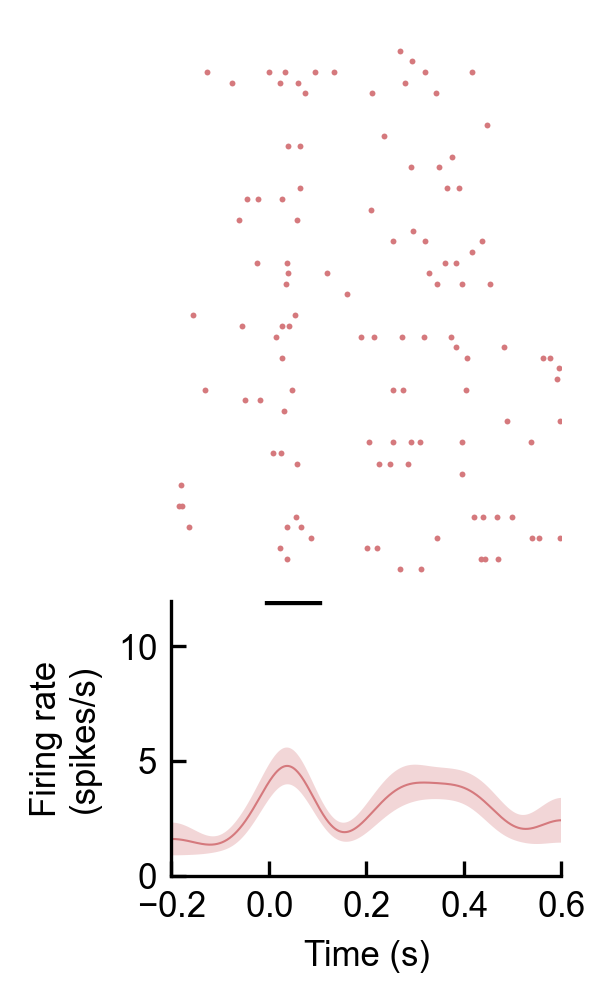

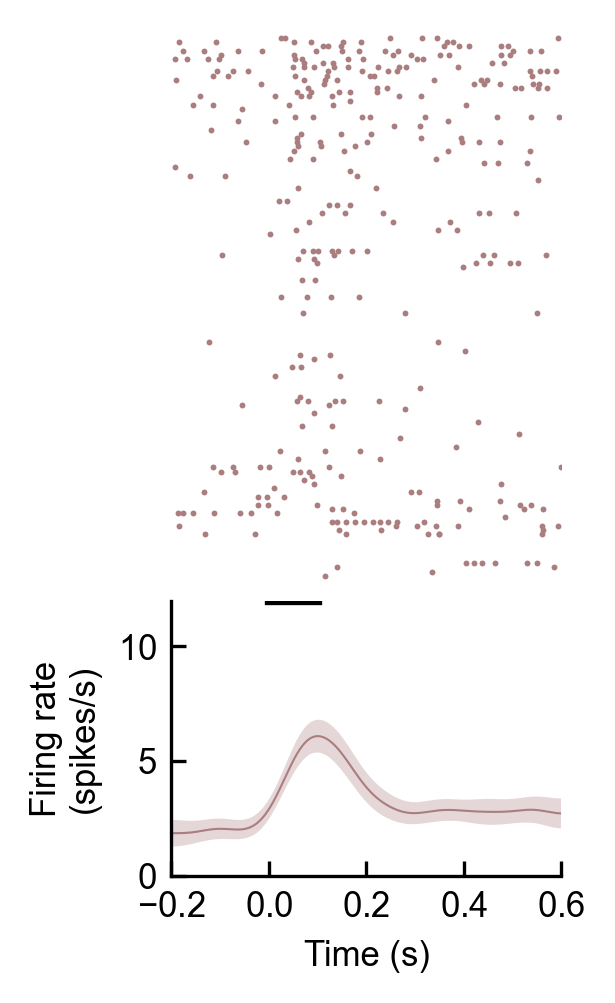

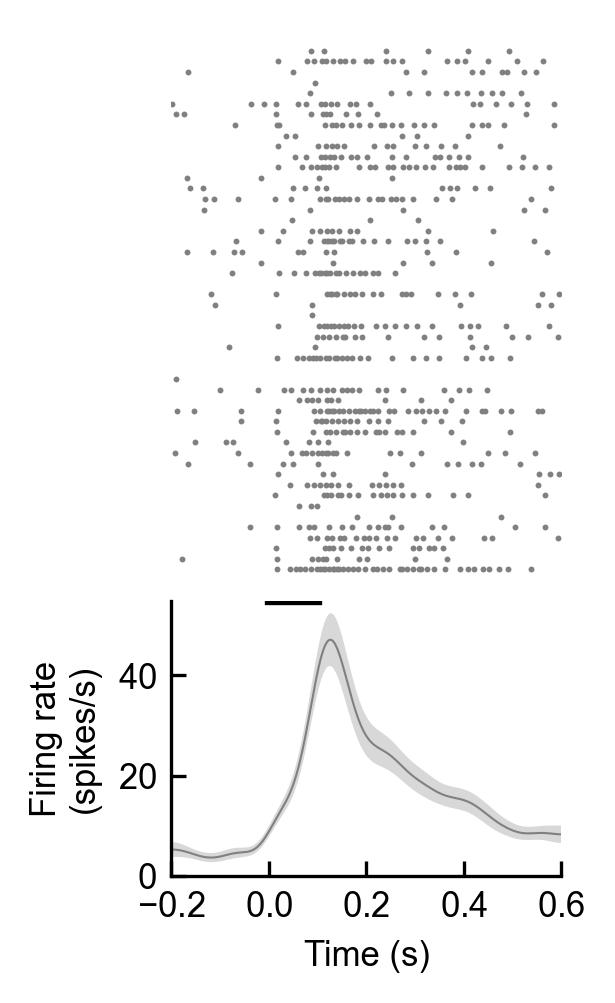

In [111]:
# Selected neurons 

# UNITS = [ ("2019-12-17", "mni11", 1), ("2020-02-12", "mni14", 4), ("2019-12-17", "mni11", 3), ("2020-01-25", "mni13", 3)]
UNITS = [ ("2019-12-17", "mni11", 1), ("2020-02-12", "mni14", 4), ("2019-12-17", "mni11", 3), ("2020-01-25", "mni13", 3)]

COLORS = [NCR_CR_cmap(i) for i in np.linspace(0, 1, len(UNITS))]

sorted_df = mouse_resp_df_2.set_index(["date", "animal", "cell_num"])

for i, (unit, color) in enumerate(zip(UNITS, COLORS)):
    date, animal, cell_num = unit
    R_st, R_ch, R = sorted_df.loc[unit][["R_st", "R_ch", "R"]]
    spikes, trials, n_trials = find_all_spikes(rec[(date, animal, cell_num)]['spikes'])
    stim_time = rec[(date, animal, cell_num)]['spikes'][0][1]
    spikes -= stim_time
    if date == "2019-10-03":
        trial_period = (-.1, .6)
    else:
        trial_period = (-.2, .6)
    try:
        fig, ax_PSTH, ax_raster = plot_raster_PSTH(spikes, trials, n_trials, show_avg_FR=False, scotts_factor=.6, figsize=(2,4), trial_period=trial_period, raster_color=color, raster_size=2, avg_FR_color=color, var_FR_color=color, var_FR_alpha=.3, y_lim=12, gridspec_kw={'bottom': .175, 'left': .25, 'hspace': .05, 'height_ratios':[2,1]})
    except:
        raise

    fig.savefig(os.path.join(MOUSE_DIR, "PSTHs_final", f"{i} {R:.02} {R_st:.02} {R_ch:.02} - {date} {animal} {cell_num}.pdf"))

### Summary

In [76]:
r_2 = {"Spiking RNN": r["Spiking RNN"], "In vivo (mouse)": mouse_resp_df_2["R"], "in vivo (rat)": r["In vivo (rat)"]}

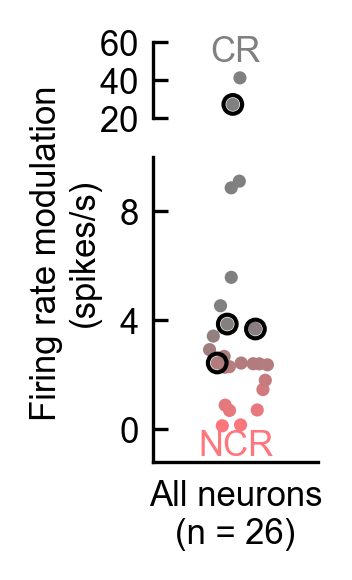

In [116]:
NAME = "mouse_modulation"
CUTOFF = 10 
TOP_Y_LIM = (20, 50)
highlights = np.array([i in UNITS for i in sorted_df.index])

fig, (ax, ax2) = plt.subplots(figsize=(1.1, 2), gridspec_kw={'left':.4, 'bottom':.18, 'height_ratios': [.2, .8]}, nrows=2, sharex=True)

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# # Making the diagonals
# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

mouse_iv = np.array(sorted_df["R"])
colors = np.array(NCR_CR_cmap(mouse_iv/4))

under_idx = mouse_iv <= CUTOFF
data_1 = mouse_iv[under_idx]
c_1 = colors[under_idx]
h_1 = highlights[under_idx]

data_2 = mouse_iv[~under_idx]
c_2 = colors[~under_idx]
h_2 = highlights[~under_idx]

plot_violin_scatter(ax2, 0, data_1, highlights=h_1, summary_size=30, size=10, width=2, summary=False, color=c_1, alpha=1)
plot_violin_scatter(ax, 0, data_2, highlights=h_2, summary_size=30, size=10, width=2, summary=False, color=c_2, alpha=1)

for a in (ax, ax2):
    a.set_xlim(-.5, .5)
    a.set_xticks([])

ax2.set_ylim(-1.2, CUTOFF)
ax.set_ylim(TOP_Y_LIM)

ax.set_yticks(range(TOP_Y_LIM[0], TOP_Y_LIM[1]+20, 20))
ax2.set_yticks(range(0, CUTOFF+1, 4))

ax2.text(0, 0, "NCR", color=NNR_COLOR, ha="center", size='small', va="top")
ax.text(0, TOP_Y_LIM[1], "CR", color=R_COLOR, ha="center", size='small')

fig.text(0.135, 0.53, "Firing rate modulation\n(spikes/s)", va='center', rotation='vertical', ha='center', fontsize='small')
ax2.set_xlabel(f'All neurons\n(n = {len(mouse_iv)})')


fig.savefig(os.path.join(MOUSE_DIR, NAME + ".pdf"))
fig.savefig(os.path.join(MOUSE_DIR, NAME + "_300.png"), dpi=300)

In [182]:
print(np.median(mouse_iv), np.percentile(mouse_iv, 25), np.percentile(mouse_iv, 75))

2.46186230219681 1.5267437193723499 3.7616935636090787
